# Titanic Predictions


RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean on April 15, 1912, after colliding with an iceberg during its voyage from Southampton, UK, to New York City, US.  Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. The sinking of Titanic is one of the most infamous shipwrecks in modern history.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we are going to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


In [88]:
# Libraries for exploratory data analysis
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
from numpy import mean
from numpy import std

# Libraries for visualisations
from matplotlib import pyplot as plt
from matplotlib import pyplot 
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)


# Libraries for evaluation of algorithms
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [2]:
# check the sickit learn version
import sklearn
print(sklearn.__version__)

1.0


## The Data


There are two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv contains the details of a subset of the passengers on board (891 to be exact) and importantly, reveals whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s our job to predict these outcomes.

Using the patterns that we will find in the train.csv data, we are going to predict whether the other 418 passengers on board (found in test.csv) survived.

In [3]:
# Load train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Summarize the Train Dataset

In [4]:
# Dimensions of the train dataset
train.shape

(891, 12)

In [5]:
# Preview the first 5 lines of loaded train dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can see that there are 12 attributes and 891 instances in the dataset.


#### Brief information about each attribute of the train dataset:

1. PassengerId: An unique index for passenger rows. It starts from 1 for first row and increments by 1 for every new rows.
2. Survived: Shows if the passenger survived or not. 1 stands for survived and 0 stands for not survived. It is the dependent (target) attribute.
3. Pclass: Ticket class: 1 - First class ticket; 2 - Second class ticket; 3 - Third class ticket.
4. Name: Passenger's name. Name also contain title: "Mr", "Mrs", "Miss", "Master", etc.
5. Sex: Passenger's sex. It's either Male or Female.
6. Age: Passenger's age. "NaN" values in this column indicates that the age of that particular passenger has not been recorded.
7. SibSp: Number of siblings or spouses travelling with each passenger.
8. Parch: Number of parents of children travelling with each passenger.
9. Ticket: Ticket number.
10. Fare: How much money the passenger has paid for the travel journey.
11. Cabin: Cabin number of the passenger. "NaN" values in this column indicates that the cabin number of that particular passenger has not been recorded.
12. Embarked: Port from where the particular passenger was embarked/boarded.



In [6]:
# Print concise summary of the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin and Embarked have missing values. Out of 891 rows, the Age values are present only in 714 rows;
Cabin values are present in only 204 rows and Embarked values are present in 889 rows.

In [7]:
# Descriptive statistics of train dataset attributes. This includes the count, mean, the
# min and max values as well as some percentiles.
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# Descriptive statistics of object data types
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dowdell, Miss. Elizabeth",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


We can see that Ticket and Cabin have duplicates. The most duplicated ticket number is 1601 which has been repeated 7 times. We also see that 644 people were embarked from port "S". Among 891 rows, 577 were Male and the rest were Female.

In [9]:
# Display number of missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age values are missing in 177 rows, cabin values are missing in 687 rows and Embarked values are missing 
in 2 rows out of 891 rows.

## Summarize the Test Dataset

In [10]:
# Dimensions of the test dataset
test.shape

(418, 11)

There are 418 instances and 11 attributes in the test dataset.

In [11]:
# Preview the first 5 lines of loaded train dataset
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Survived attribute is not present in the test data. We have to train our classifier of the train dataset and generate predictions (Survived) on the test dataset.

In [12]:
# Print concise summary of the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Age, Cabin and Fare have missing values. Age values are present in 332 rows out of 418 rows.
Fare values are present in 417 rows and Cabin values are present in 91 rows.

In [13]:
# Descriptive statistics of test dataset attributes. This includes the count, mean, the
# min and max values as well as some percentiles.
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [14]:
# Display number of missing values
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Age values are missing in 86 rows, Cabin values are missing in 327 rows and Fare values are missing in 1 row
out of 418 rows.

## Class Distribution

In [15]:
# Class distribution
print(train.groupby('Survived').size())

Survived
0    549
1    342
dtype: int64


Very imbalanced class distribution. There are 549 instances that belong to "0" class which stands for not survived and 342 instances belong to "1" class which refers to survived.

Survived: 342 (38.4%)
Not Survived: 549 (61.6%)
Total: 891


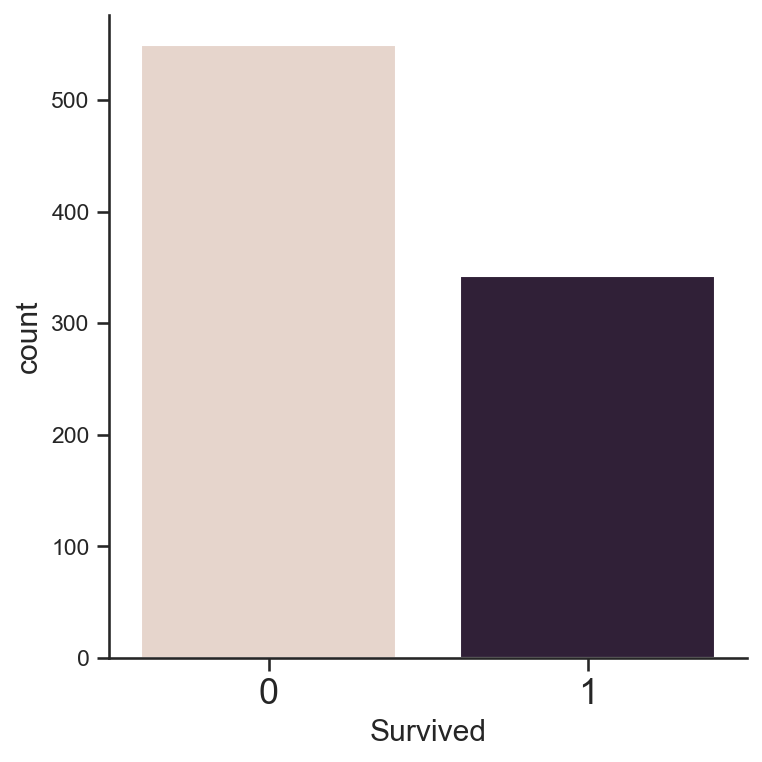

In [16]:
# Class distribution in percentage
survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]

print ("Survived: %i (%.1f%%)"%(len(survived), float(len(survived))/len(train)*100.0))
print ("Not Survived: %i (%.1f%%)"%(len(not_survived), float(len(not_survived))/len(train)*100.0))
print ("Total: %i"%len(train))

# Plot the count of not_survived ("0") and survived ("1") with seaborn catplot
sns.catplot(x="Survived", kind="count", palette = "ch:s=.100", data=train)

## Data Visualisation


We have now a basic idea about the data. We are going to extend this with some visualisations. We are going to visualize the relationship between attributes with respect to the target attribute "Survived". We will see how different attribute values show different survival chance.



#### Sex vs Survived

Female: 314 (35.2%)
Male: 577 (64.8%)
Total: 891


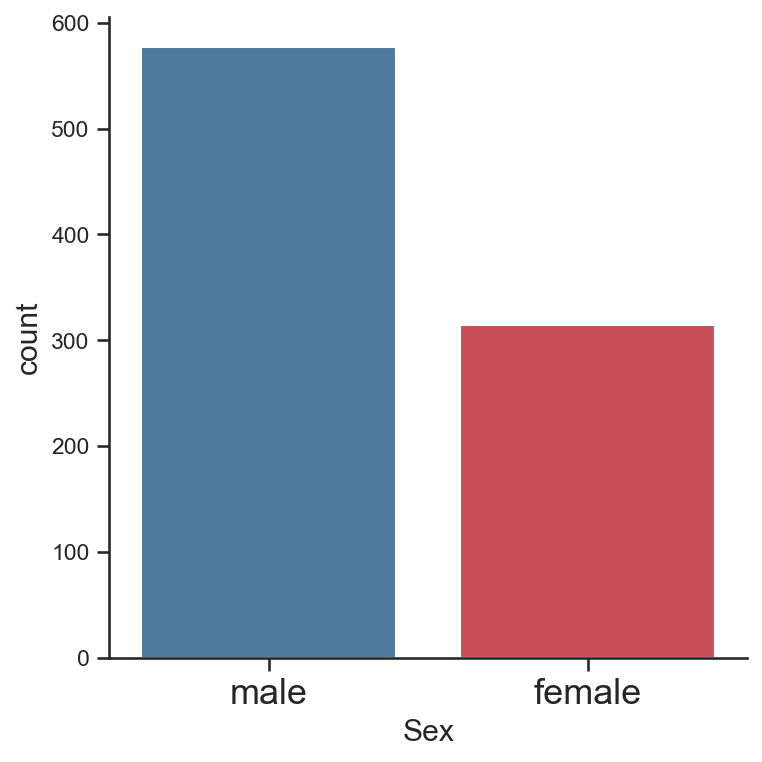

In [17]:
# Frequences of Sex attribute
female = train[train['Sex'] == "female"]
male = train[train['Sex'] == "male"]

print ("Female: %i (%.1f%%)"%(len(female), float(len(female))/len(train)*100.0))
print ("Male: %i (%.1f%%)"%(len(male), float(len(male))/len(train)*100.0))
print ("Total: %i"%len(train))

# Plot the count of women and men with seaborn catplot
color = sns.diverging_palette(240, 10, n=2)
sns.catplot(x="Sex", kind="count", palette = color, data=train)

% of women who survived: 74.20%
% of men who survived: 18.89%


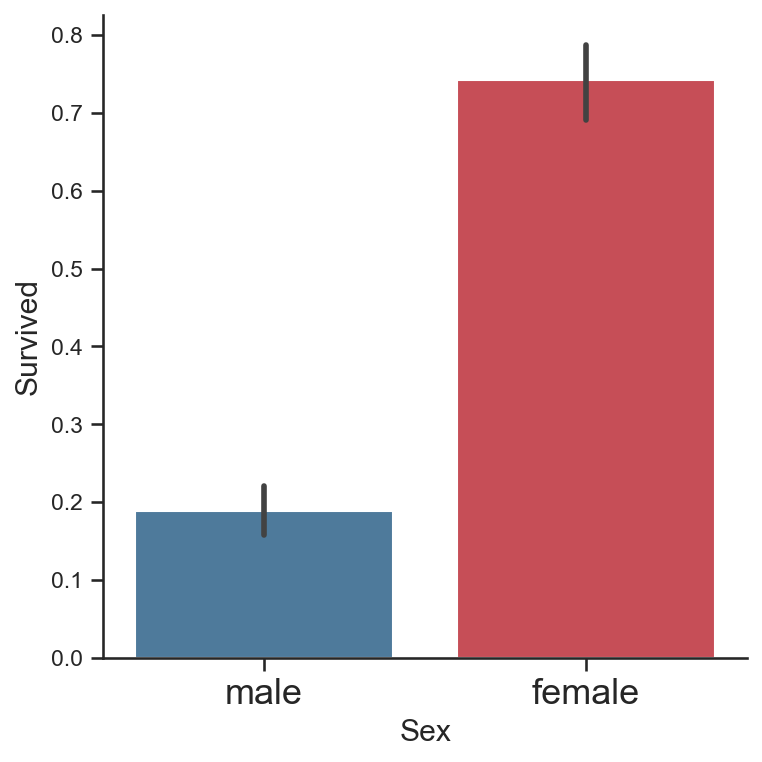

In [18]:
# Percentage of women and and men who survived
women = train.loc[train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

men = train.loc[train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of women who survived:","{:.2%}".format(rate_women))
print("% of men who survived:", "{:.2%}".format(rate_men))

# Plot the rate of women and men who survived
color = sns.diverging_palette(240, 10, n=2)
sns.catplot(x='Sex', y='Survived', kind = "bar", palette = color, data=train)

It looks that women had a greater chance to survive than men.

#### Pclass vs Survived

In [19]:
# Count of passengers by Pclass
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

The third class is the most populated. There are 491 passangers out of 891 passangers.

In [20]:
# Count of passangers who survived or not_survived by Pclass
train.groupby('Pclass').Survived.value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

372 passangers from the third class did not survive.

In [21]:
# Count of passangers by Sex by Pclass
train.groupby('Pclass').Sex.value_counts()

Pclass  Sex   
1       male      122
        female     94
2       male      108
        female     76
3       male      347
        female    144
Name: Sex, dtype: int64

There are a lot of males (347) among third class passangers.

#### Sex vs Survived by Pclass

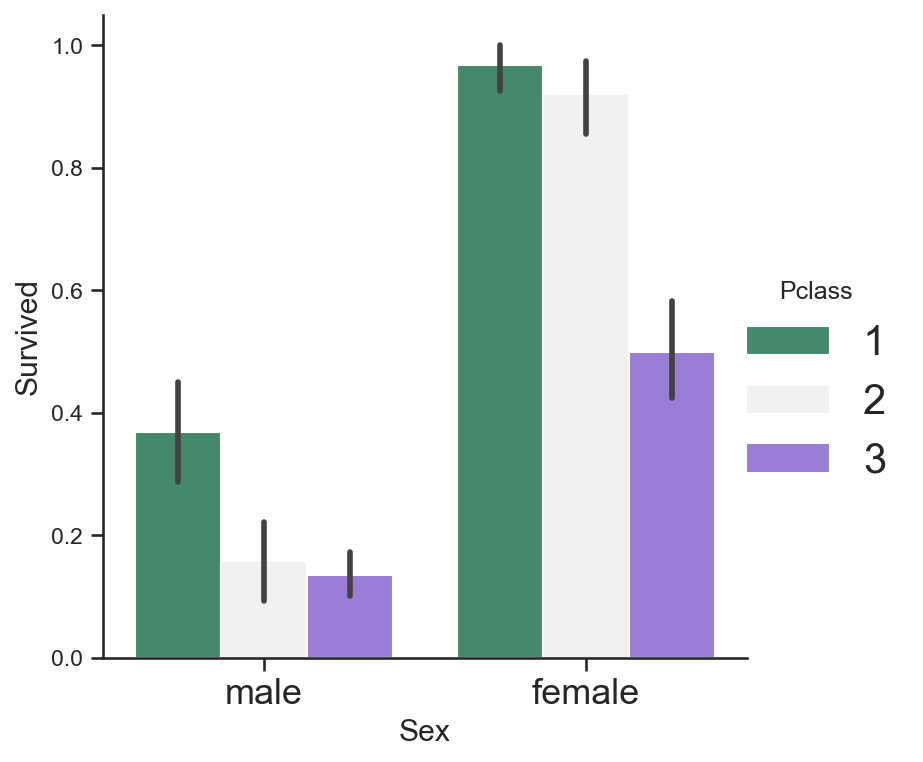

In [22]:
# Plot the rate of women and men who survived by Pclass
color = sns.diverging_palette(150, 275, s=80, l=55, n=3)
sns.catplot(x='Sex', y='Survived', kind = "bar", hue = 'Pclass', palette = color, data=train)

From the above plot, it can be seen that:

- Women from 1st and 2nd Pclass have almost 100% survival chance.
- Men from 2nd and 3rd Pclass have less than 20% survival chance.



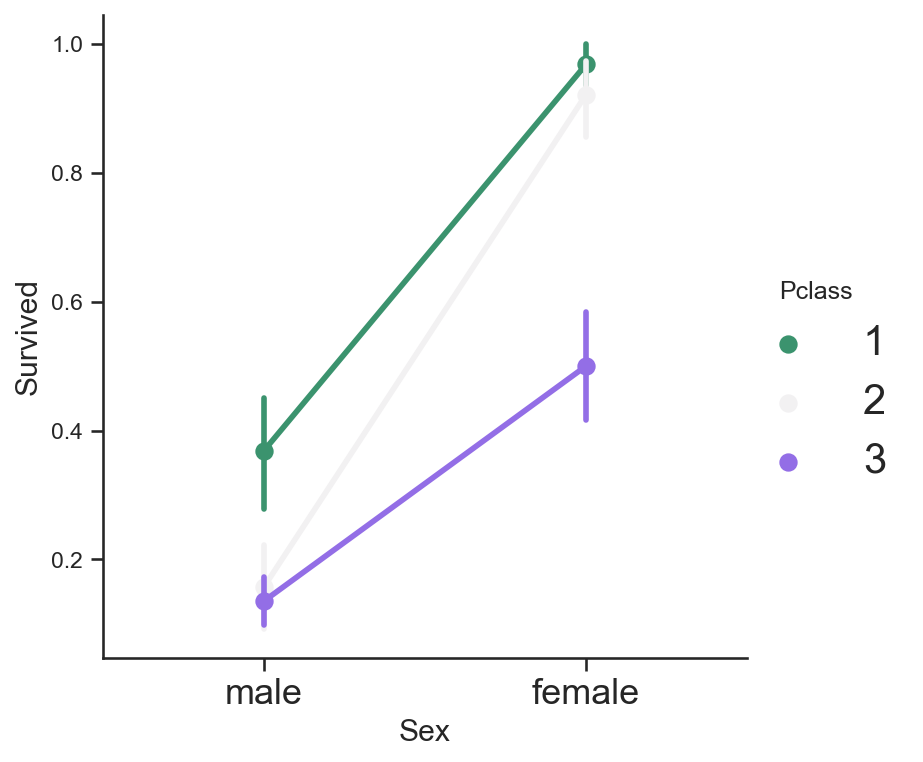

In [23]:
# The same information as above with point plot
color = sns.diverging_palette(150, 275, s=80, l=55, n=3)
sns.catplot(x="Sex", y="Survived", hue="Pclass", palette = color, kind="point", data=train)

This function pointplot() also encodes the value of the estimate with height on the other 
axis, but rather than showing a full bar, it plots the point estimate and confidence 
interval. Additionally, pointplot() connects points from the same hue category. 
This makes it easy to see how the main relationship is changing as a function of the hue 
semantic, because our eyes are quite good at picking up on differences of slopes.

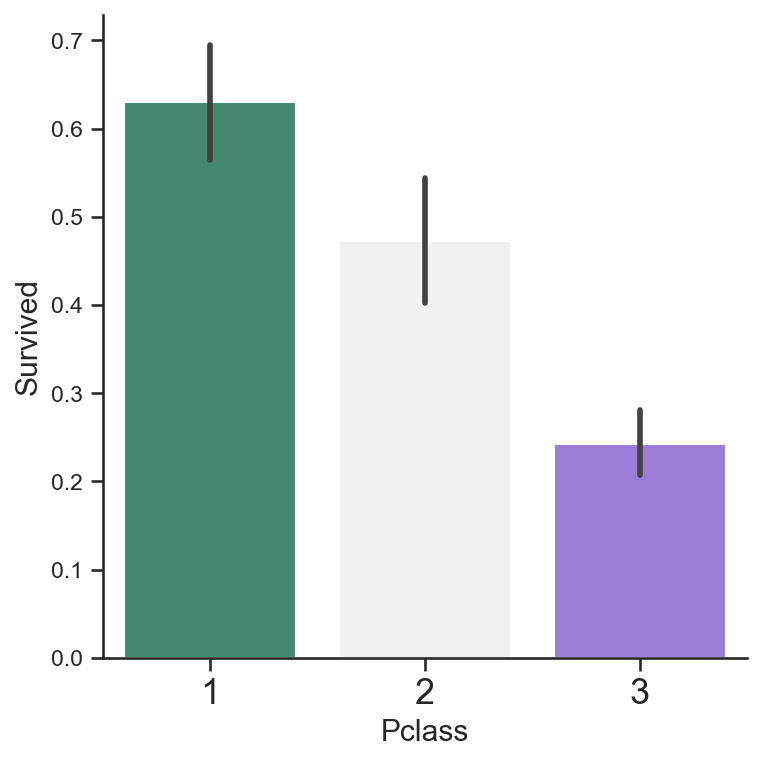

In [24]:
# Rate of passangers who survived by Pclass
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

# Plot the rate of passangers who survived by Pclass
color = sns.diverging_palette(150, 275, s=80, l=55, n=3)
sns.catplot(x='Pclass', y='Survived', kind = "bar", palette = color, data=train)

The highest survival chance (above 60%) is related to first class passangers.

#### Pclass vs Survived by Embarked & Sex

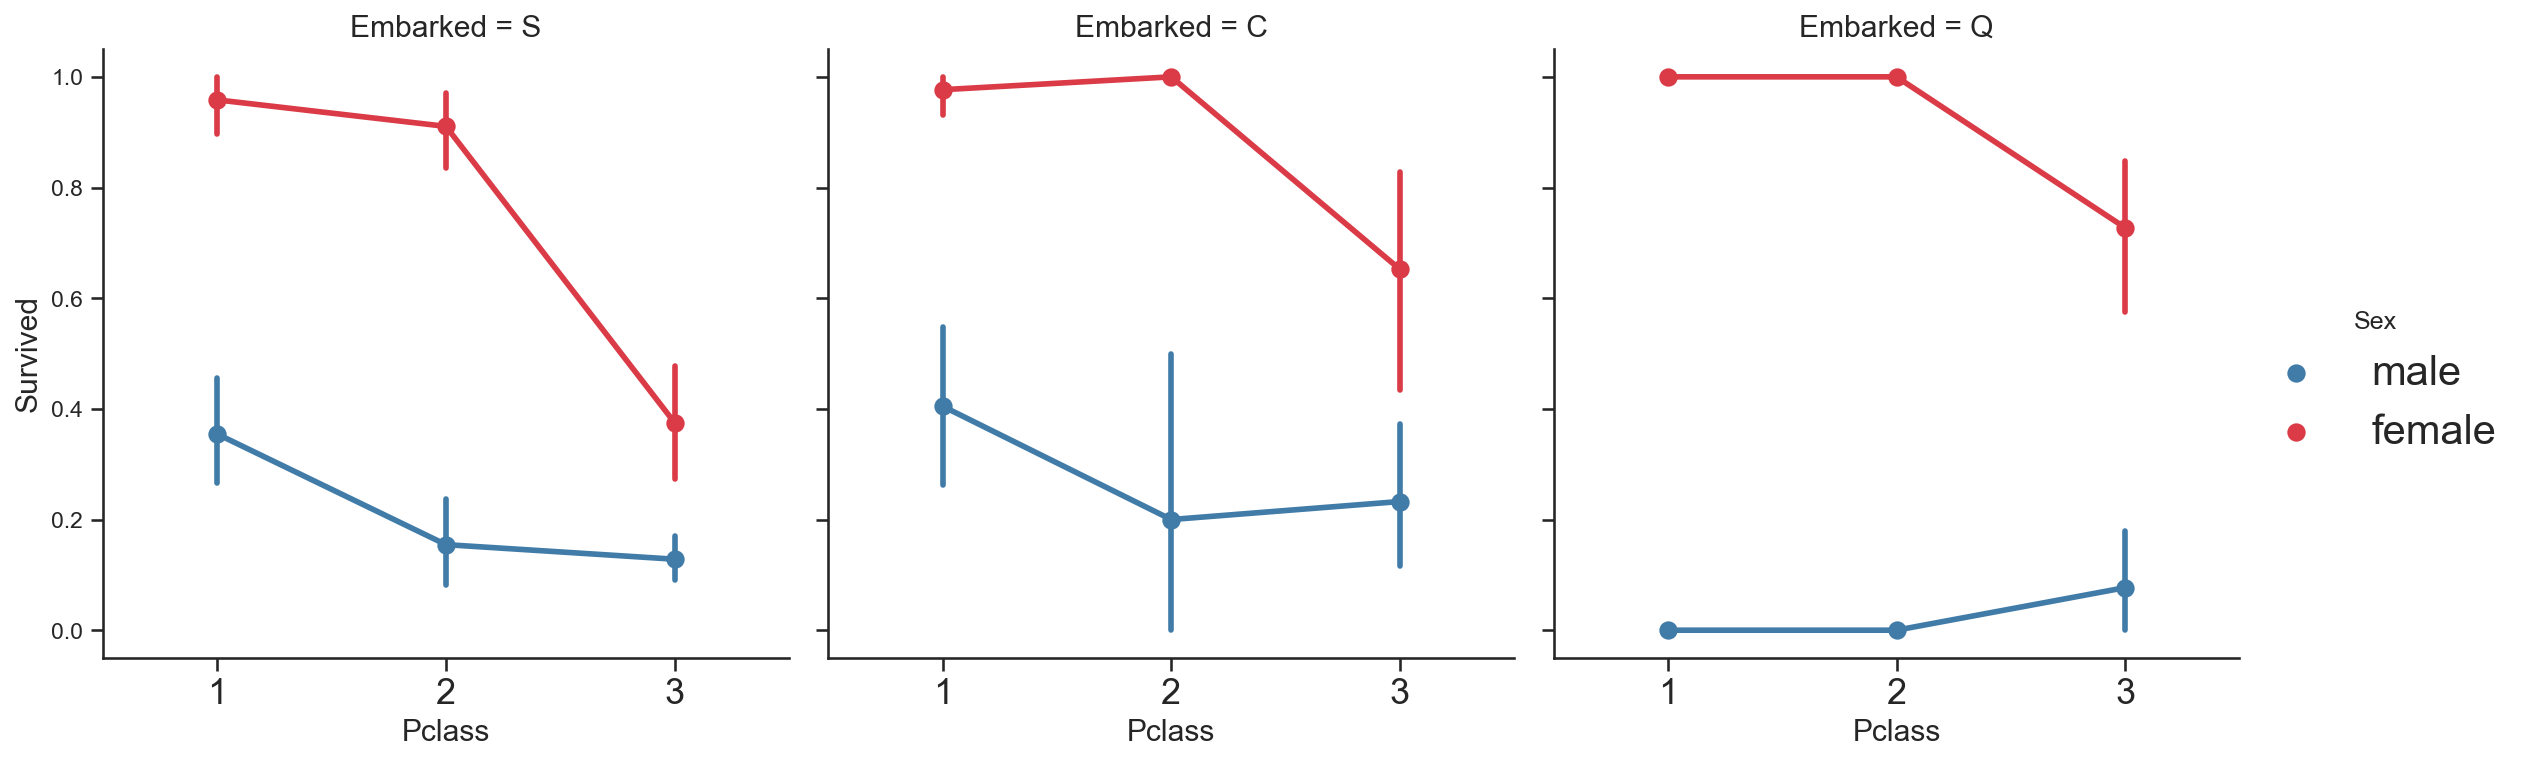

In [25]:
color = sns.diverging_palette(240, 10, n=2)
sns.factorplot(x='Pclass', y='Survived', hue='Sex', 
               col='Embarked', palette = color, 
               data=train)



From the above plots, it can be seen that:

 - Almost all women from Pclass 1 and 2 survived and had the greatest chance of survival.
 - Men from Pclass 1 only have slightly higher survival chance than Pclass 2 and 3.



#### Age vs. Survival

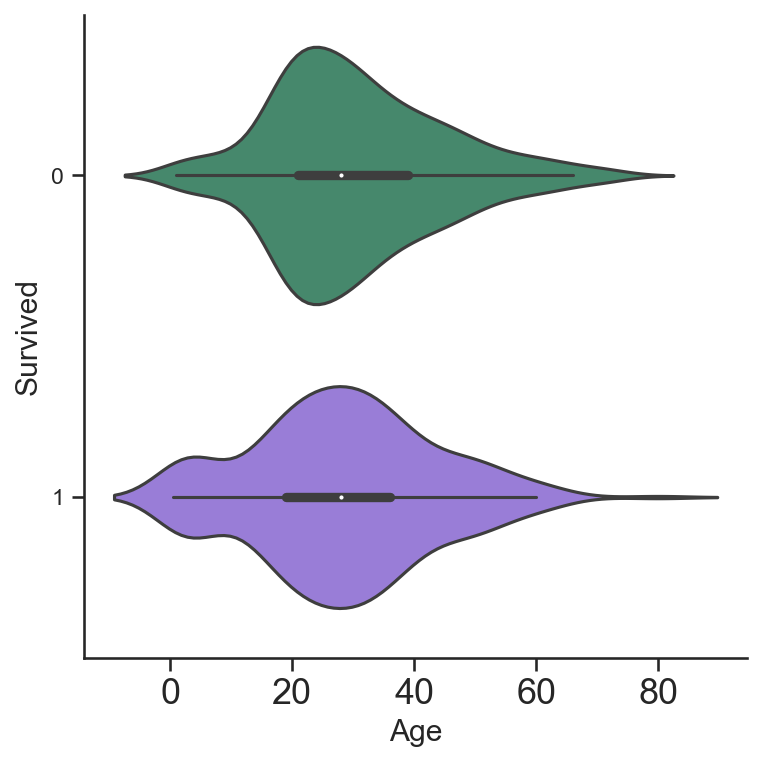

In [26]:
# Plot the Survived attribute versus Age
color = sns.diverging_palette(150, 275, s=80, l=55, n=2)
sns.factorplot('Age',  'Survived',  data = train, hue_order = [1,0], orient="h", palette=color, kind="violin")

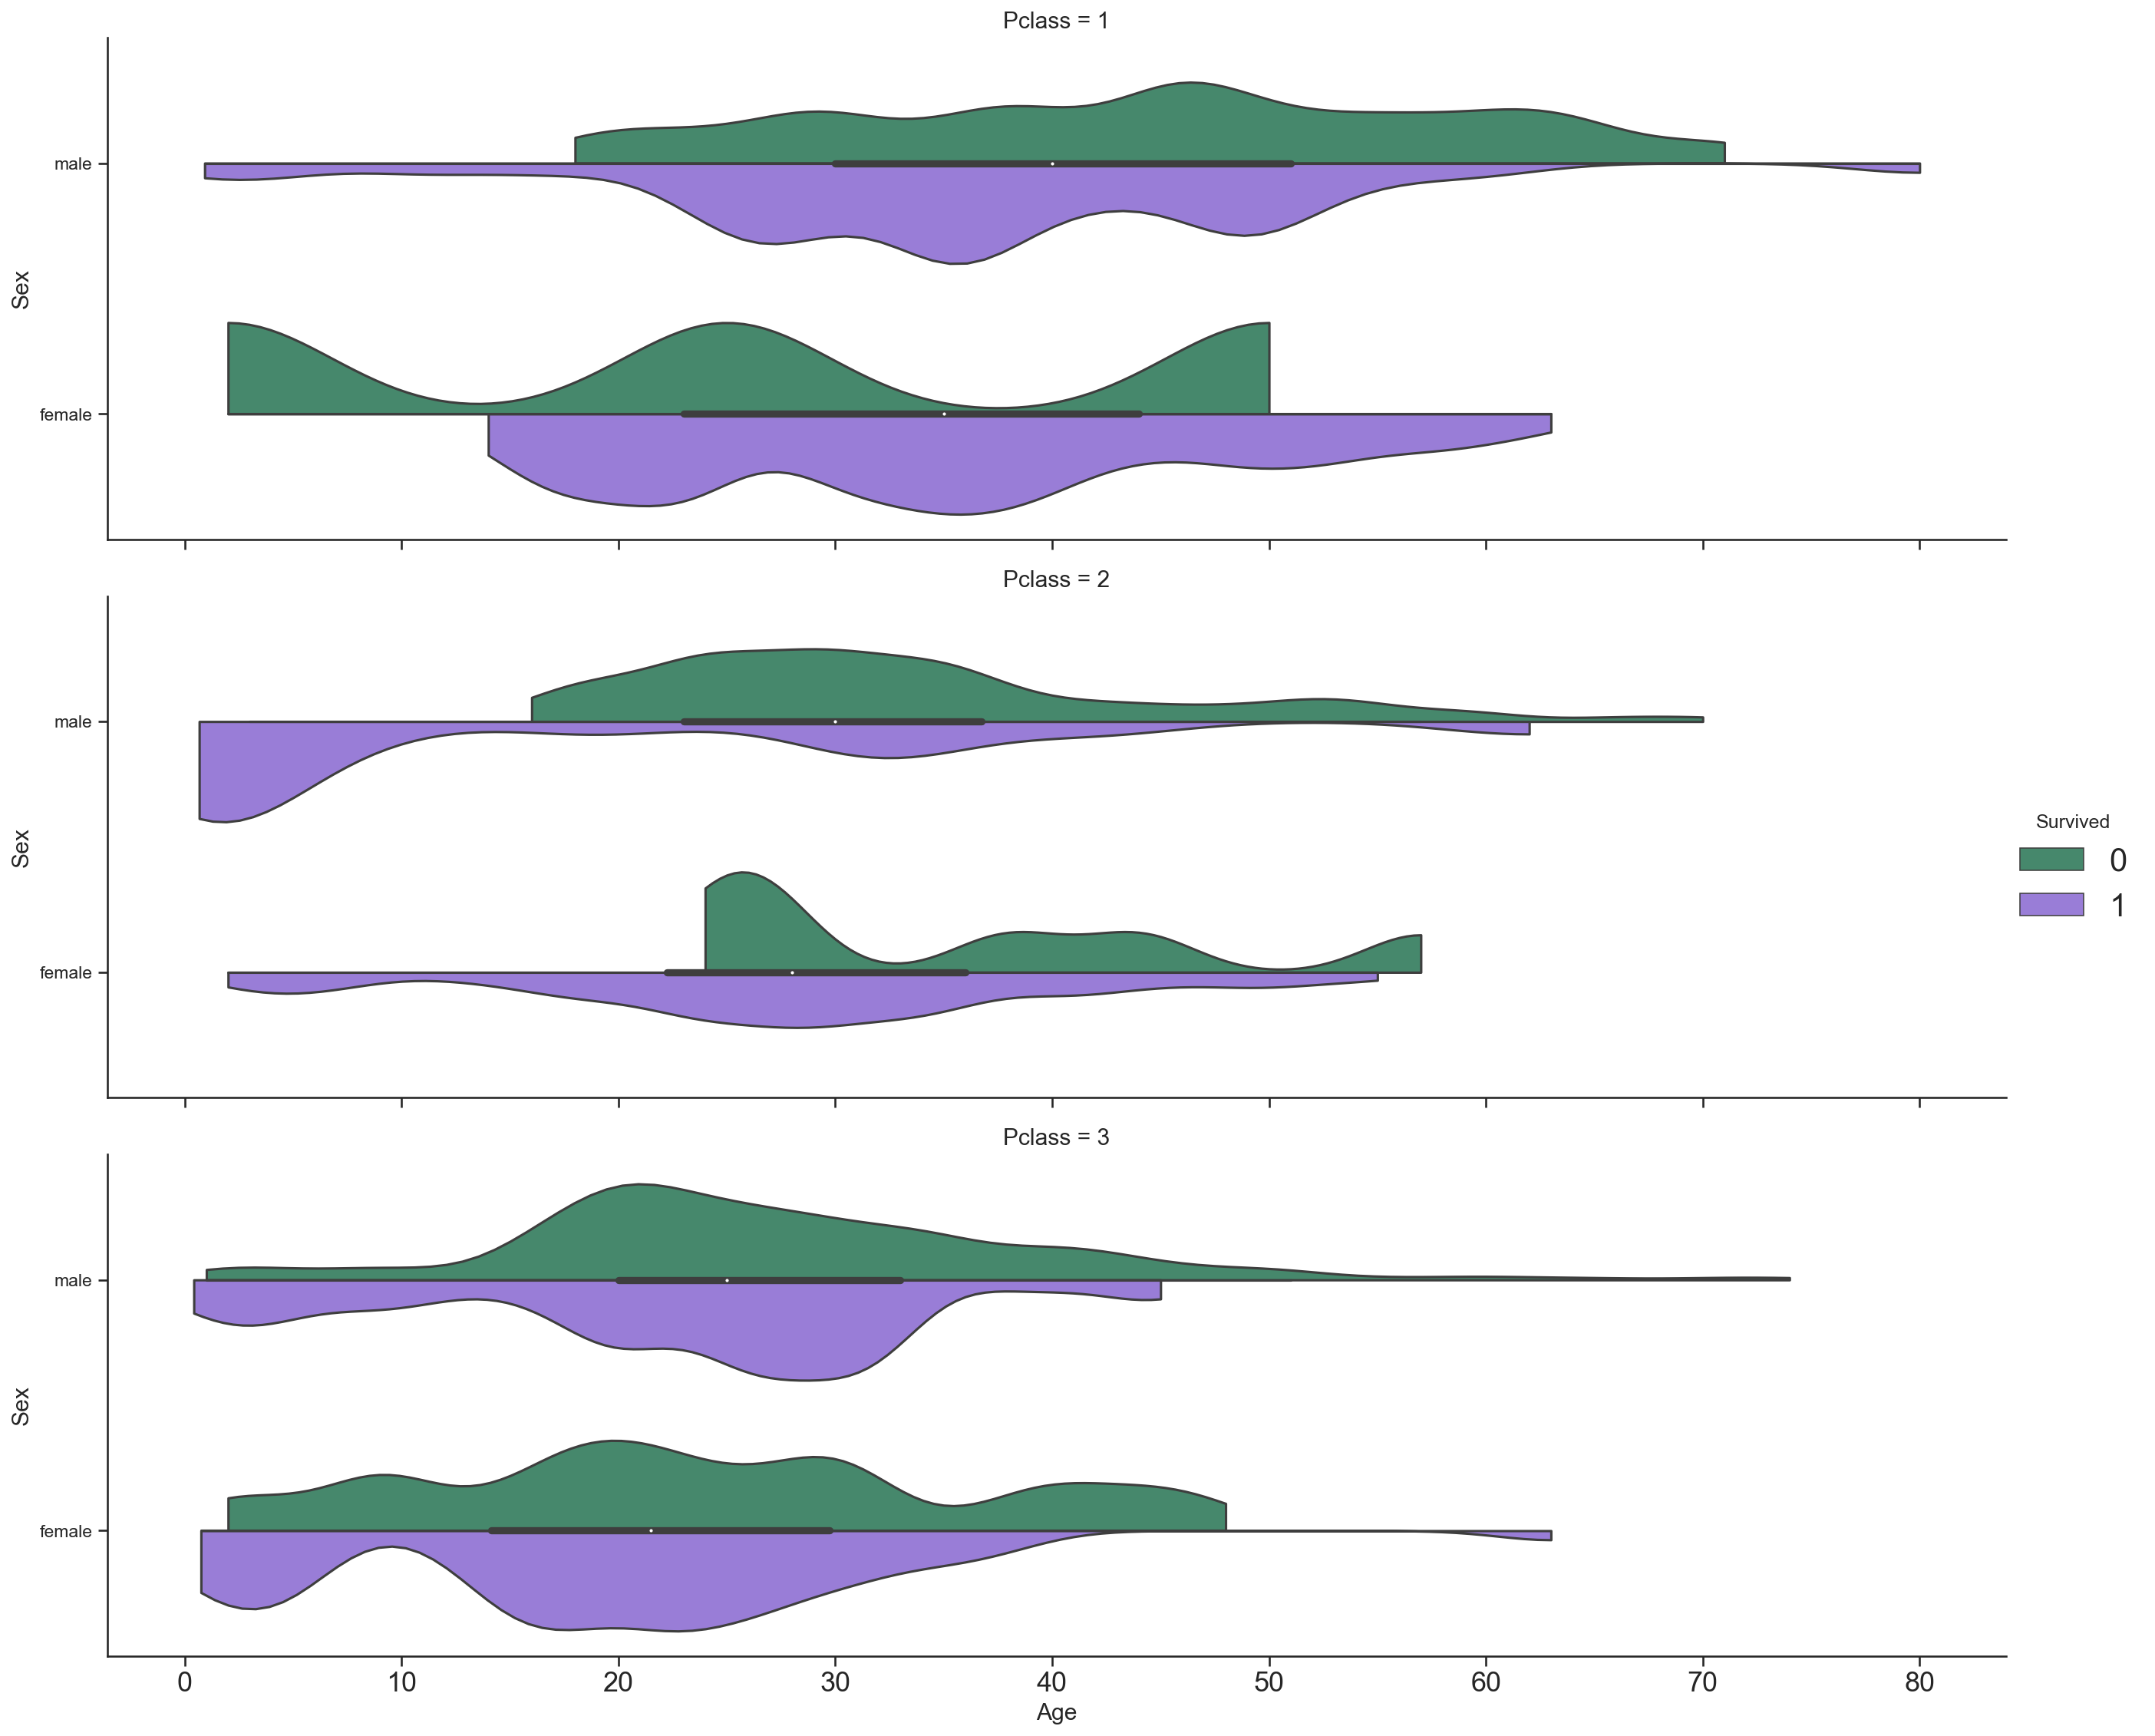

In [27]:
# Violin plots of Age versus sex by Pclass
color = sns.diverging_palette(150, 275, s=80, l=55, n=2)
plot = sns.factorplot('Age','Sex', hue = 'Survived',row = 'Pclass',  
                      data = train, hue_order = [0,1],
                      orient="h",  aspect=3.5, palette=color,
                      kind="violin", split=True, cut=0, bw=.2)
(plot.set_axis_labels("Age", "Sex"))



From violinplots, we can see that:

 - There were not so many children in the first Pclass, mostly boys (between age 0-18) who survived.
 - Almost all children (between age 0 to 10), boys and girls of second and third Pclass survived.
 - Younger passangers of first Pclass survived as compared to its older people.



<AxesSubplot:xlabel='Male Age'>

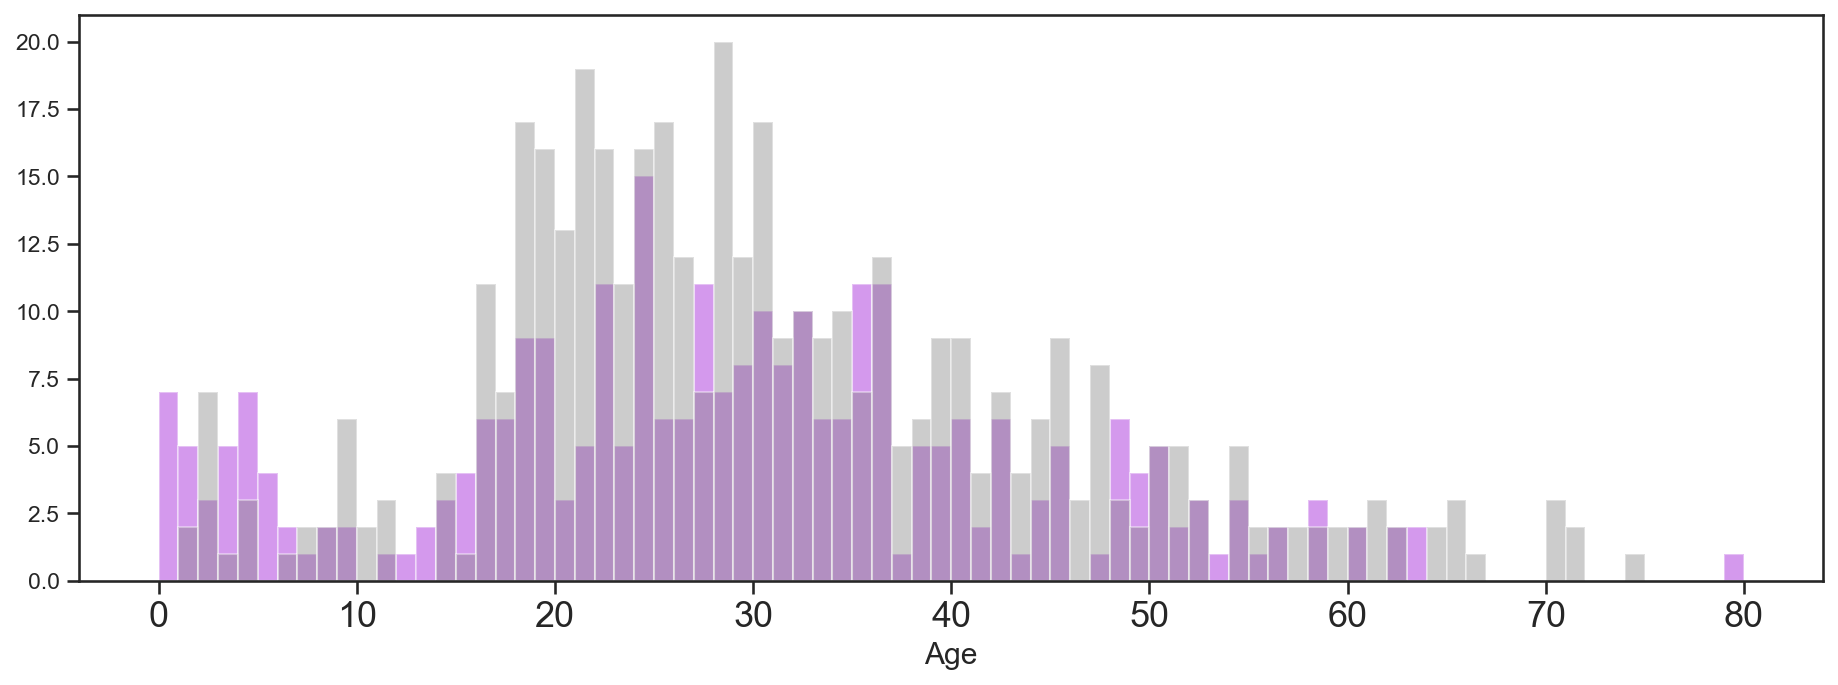

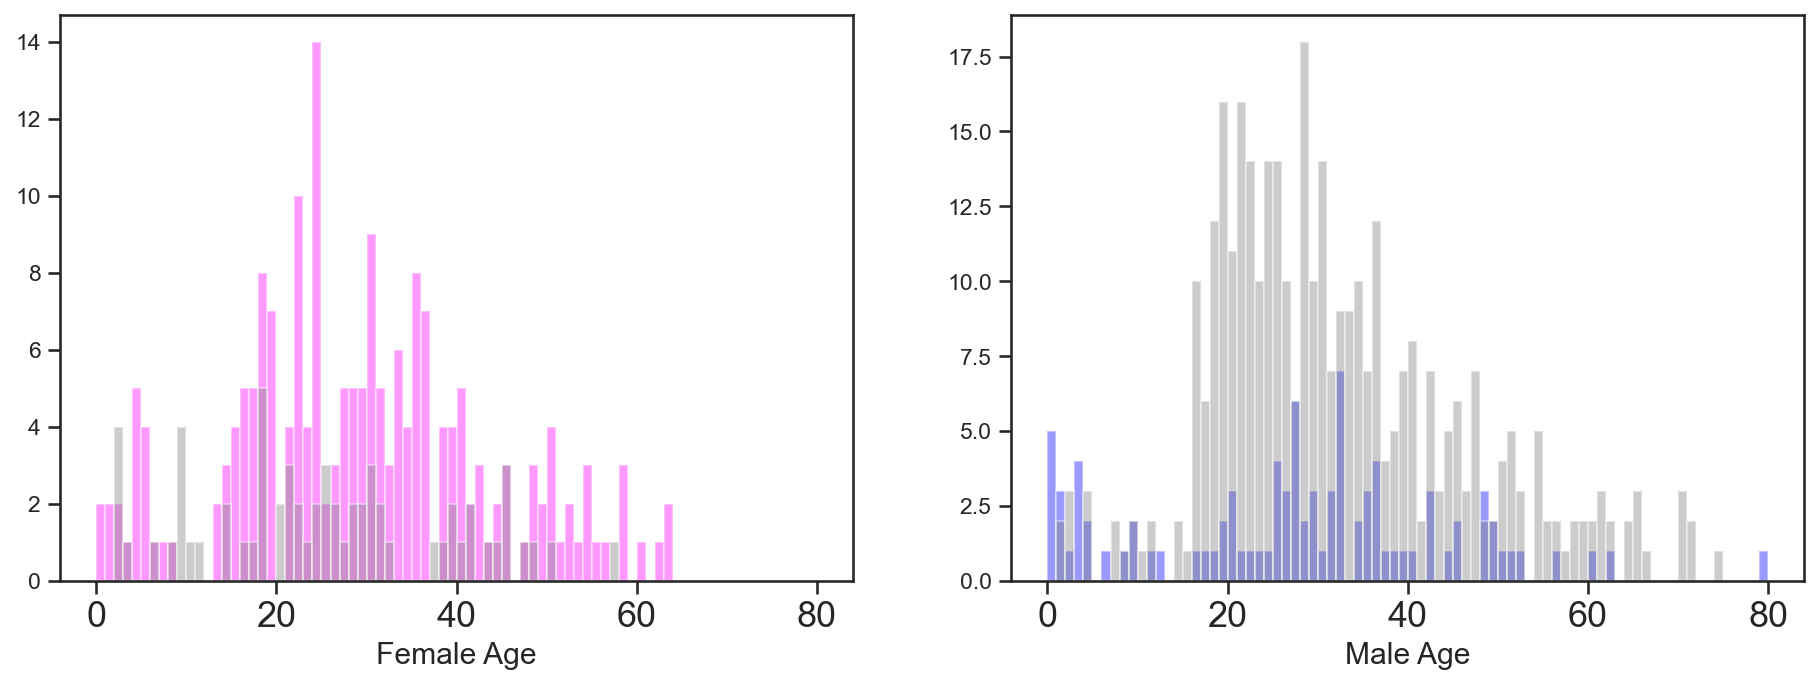

In [28]:
# Define the sub-categories
total_survived = train[train['Survived']==1]
total_not_survived = train[train['Survived']==0]
male_survived = train[(train['Survived']==1) & (train['Sex']=="male")]
female_survived = train[(train['Survived']==1) & (train['Sex']=="female")]
male_not_survived = train[(train['Survived']==0) & (train['Sex']=="male")]
female_not_survived = train[(train['Survived']==0) & (train['Sex']=="female")]

# Plot histogram of Age of all passangers (survived and not survived)
plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_survived['Age'].dropna().values, bins=range(0, 81, 1), 
             kde=False, color='darkviolet')
sns.distplot(total_not_survived['Age'].dropna().values, bins=range(0, 81, 1), 
             kde=False, color='grey', axlabel='Age')

# Histogram of Age of all female passangers
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.distplot(female_survived['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='magenta')
sns.distplot(female_not_survived['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='grey', axlabel='Female Age')

# Histogram of Age of all male passangers
plt.subplot(122)
sns.distplot(male_survived['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='blue')
sns.distplot(male_not_survived['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='grey', axlabel='Male Age')

## Correlation Matrix

<AxesSubplot:>

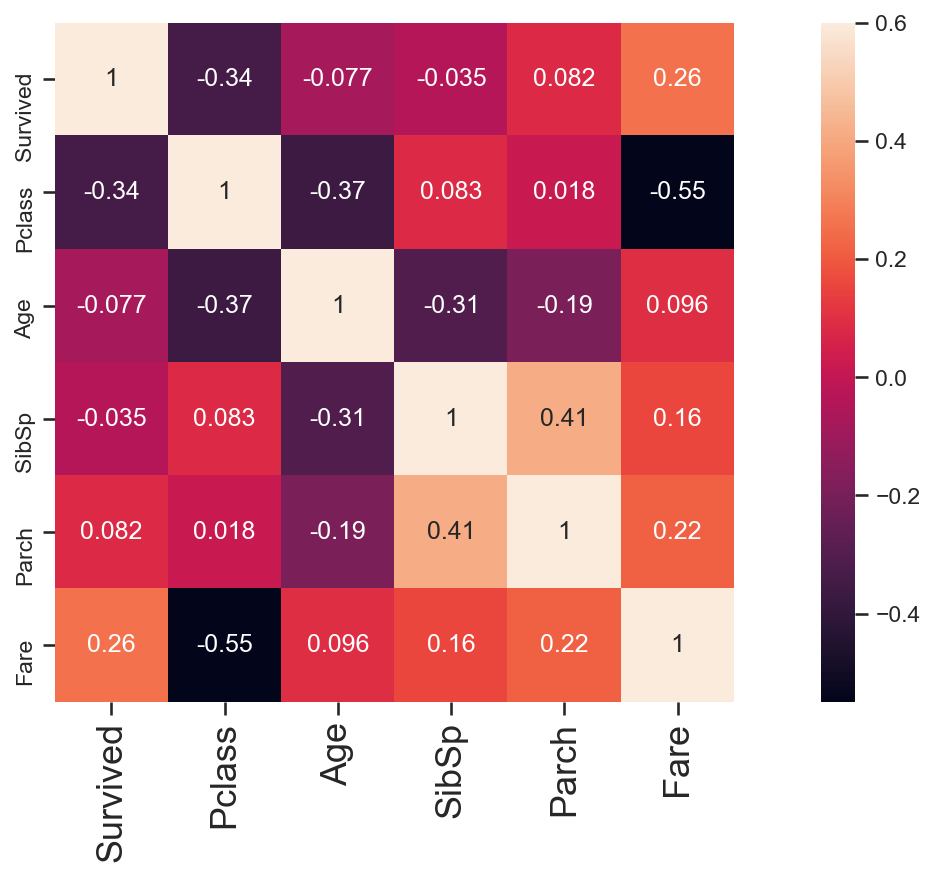

In [29]:
plt.figure(figsize=(15,6))
sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)



Heatmap of correlation between different attributes:

- Positive numbers show positive correlations, i.e. increase in one attribute will increase the other attribute & vice-versa. 

- Negative numbers show negative correlations, i.e. increase in one one will decrease the other attribute & vice-versa. 

We are looking for removal of the most correlated attributes to better improve the accuracy of the models later on.

## Feature Engineering


In [30]:
# Create a function that alerts if the feature has been processed
def status(feature):
    print('Processing', feature, ': ok')

## Loading the Data
One trick when starting a machine learning problem is to append the training set to the test set together.

We'll engineer new features using the train set to prevent information leakage. Then we'll add these variables to the test set.

Let's load the train and test sets and append them together.

In [31]:
# Define a function that appends both datasets (train and test data)
def get_combined_data():
    
    # Read train data
    train = pd.read_csv('train.csv')
    
    # Read test data
    test = pd.read_csv('test.csv')

    # Extract and remove the target attrinbute Survived from the train data 
    targets = train.Survived
    train.drop(['Survived'], 1, inplace=True)
    

    # Append train data to test data and remove the PassengerID 
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace=True, axis=1)
    
    return combined

combined = get_combined_data()

In [32]:
# Dimensions of combined data
print(combined.shape)

(1309, 10)


In [33]:
# Peek at the first 5 rows
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Extracting the Passenger Titles from the Name Feature

If you look closely at these first examples:

Braund, Mr. Owen Harris
Heikkinen, Miss. Laina
Oliva y Ocana, Dona. Fermina
Peter, Master. Michael J
You will notice that each name has a title in it ! This can be a simple Miss. or Mrs., but it can be sometimes something more sophisticated like Master, Sir or Dona. In that case, we might introduce an additional information about the social status by simply parsing the name and extracting the title and converting to a binary variable.


In [34]:
# Extract titles from Name feature
titles = set()
for name in combined['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

print(titles)

{'Mme', 'Mlle', 'Lady', 'Don', 'Ms', 'Mrs', 'Col', 'Capt', 'the Countess', 'Major', 'Sir', 'Dr', 'Master', 'Jonkheer', 'Dona', 'Mr', 'Miss', 'Rev'}


In [35]:
# Create dictionary of sub-category of titles
Title_Dictionary = {
    "Mlle": "Miss",
    "Capt": "Mr",
    "the Countess":"Mrs",
    "Mme": "Mrs",
    "Sir": "Mr",
    "Mrs": "Mrs",
    "Rev": "Other",
    "Jonkheer": "Other",
    "Col" : "Other",
    "Major": "Mr",
    "Dona": "Mrs",
    "Miss": "Miss",
    "Mr" : "Mr",
    "Lady" : "Mrs",
    "Don" : "Mr",
    "Dr" : "Other",
    "Ms" : "Miss",
    "Master": "Mr"
}

# Define a function that parses the Name feature, extracts the titles and map them
# to sub-categories of titles
def get_titles():
    
    # Extract the titles from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # Map each title to the relevant sub-category
    combined['Title'] = combined.Title.map(Title_Dictionary)
    status('Title')
    return combined


In [36]:
combined = get_titles()
combined.head()

Processing Title : ok


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [37]:
# Check if the titles have been filled correctly
combined[combined['Title'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


## Age Feature

In [38]:
# Number of missing values of Age in train and test data
print(combined.iloc[:891].Age.isnull().sum())
print(combined.iloc[891:].Age.isnull().sum())

177
86


In [39]:
# Group the combined data by Sex, Pclass and Title and for each subset, produce a median age
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
# Convert from float to integer data type of Age
grouped_median_train['Age'] = grouped_median_train['Age'].round(0).astype('int')
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30
1,female,1,Mrs,40
2,female,1,Other,49
3,female,2,Miss,24
4,female,2,Mrs,32


In [40]:
# Create a function that defines the condition to fill in missing values of Age by group
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


# Create a function that fills in of the missing values of Age
def process_age():
    global combined
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('age')
    return combined

combined = process_age()

Processing age : ok


In [42]:
# Check the missing values after filling in
print(combined.iloc[:891].Age.isnull().sum())
print(combined.iloc[891:].Age.isnull().sum())

0
0


In [43]:
# Replace numeric Age values with single integer according to which age group it belongs
combined['Age'] = pd.cut(combined['Age'], bins=[0,16,32,48,64, 80], right=True, labels=False)+1
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,2,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,2,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,3,0,0,373450,8.0500,NaN,S,Mr


In [44]:
# Count the number of passangers by age group
combined.Age.value_counts()

2    749
3    307
1    134
4    106
5     13
Name: Age, dtype: int64

In [45]:
# Define a function for encoding Title feature as numeric dummy variables
def process_titles():
    global combined
    # Remove the Name feature
    combined.drop('Name', axis=1, inplace=True)
    
    # Encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)
    
    # Remove the Title feature
    combined.drop('Title', axis=1, inplace=True)
    
    status('names')
    return combined

In [46]:
combined = process_titles()
combined.head()

Processing names : ok


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,3,male,2,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0
1,1,female,3,1,0,PC 17599,71.2833,C85,C,0,0,1,0
2,3,female,2,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0
3,1,female,3,1,0,113803,53.1000,C123,S,0,0,1,0
4,3,male,3,0,0,373450,8.0500,NaN,S,0,1,0,0


## Fare Feature

In [47]:
# Number of missing values of Fare in train and test data
print(combined.iloc[:891].Fare.isnull().sum())
print(combined.iloc[891:].Fare.isnull().sum())

0
1


In [48]:
# Replase 1 missing value with a median value in combined data
def process_fares():
    global combined
    
    # There's one missing fare value - replacing it with the median.
    combined.Fare.fillna(combined.iloc[:891].Fare.median(), inplace=True)
    status('fare')
    return combined

In [49]:
combined = process_fares()

Processing fare : ok


In [50]:
# Check the missing values after fillin in
print(combined.iloc[:891].Fare.isnull().sum())
print(combined.iloc[891:].Fare.isnull().sum())

0
0


In [51]:
# Binning - replace Fare values with single integer according to which fare group it belongs
combined['Fare'] = pd.cut(combined.Fare, bins=[-0.001,7.896,14.454,31.275, 512.3292], right=True, labels=False)+1
combined.head()


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,3,male,2,1,0,A/5 21171,1,NaN,S,0,1,0,0
1,1,female,3,1,0,PC 17599,4,C85,C,0,0,1,0
2,3,female,2,0,0,STON/O2. 3101282,2,NaN,S,1,0,0,0
3,1,female,3,1,0,113803,4,C123,S,0,0,1,0
4,3,male,3,0,0,373450,2,NaN,S,0,1,0,0


In [52]:
# Count the number of passangers by fare group
combined.Fare.value_counts()

3    339
1    337
4    323
2    310
Name: Fare, dtype: int64

## Embarked Feature

In [53]:
# Determine unique values in Embarked feature
combined.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [54]:
# Frequences of Embarked feature
combined.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [55]:
# Number of missing values of Embarked in train and test data
print(combined.iloc[:891].Embarked.isnull().sum())
print(combined.iloc[891:].Embarked.isnull().sum())

2
0


In [56]:
def process_embarked():
    global combined
    
    # Filling the 2 missing values with the most frequent sub-category ("S") in the train data
    combined.Embarked.fillna('S', inplace=True)
    
    # Dummy encoding of Embarked sub-categories
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis=1, inplace=True)
    status('embarked')
    return combined

In [57]:
combined = process_embarked()
combined.head()

Processing embarked : ok


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_C,Embarked_Q,Embarked_S
0,3,male,2,1,0,A/5 21171,1,NaN,0,1,0,0,0,0,1
1,1,female,3,1,0,PC 17599,4,C85,0,0,1,0,1,0,0
2,3,female,2,0,0,STON/O2. 3101282,2,NaN,1,0,0,0,0,0,1
3,1,female,3,1,0,113803,4,C123,0,0,1,0,0,0,1
4,3,male,3,0,0,373450,2,NaN,0,1,0,0,0,0,1


## Cabin Feature

In [58]:
# Determine unique values in Embarked feature
combined.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [59]:
# Frequences of Cabin feature
combined.Cabin.value_counts()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
D                  4
C22 C26            4
                  ..
E45                1
A29                1
E58                1
C130               1
A11                1
Name: Cabin, Length: 186, dtype: int64

In [60]:
# Number of missing values of Cabin in train and test data
print(combined.iloc[:891].Cabin.isnull().sum())
print(combined.iloc[891:].Cabin.isnull().sum())

687
327


In [61]:
# Check the letters in train and test data
train_cabin, test_cabin = set(), set()

for c in combined.iloc[:891]['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')
        
for c in combined.iloc[891:]['Cabin']:
    try:
        test_cabin.add(c[0])
    except:
        test_cabin.add('U')

print(train_cabin)

print(test_cabin)

{'U', 'T', 'F', 'C', 'E', 'A', 'B', 'G', 'D'}
{'U', 'F', 'C', 'A', 'E', 'B', 'G', 'D'}


All the letters in test data are present in train data.

In [62]:
def process_cabin():
    global combined    
    # Replacing missing values with U (for Uknown)
    combined.Cabin.fillna('U', inplace=True)
    
    # Map each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])
    
    # Dummy encoding
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
    combined = pd.concat([combined, cabin_dummies], axis=1)

    combined.drop('Cabin', axis=1, inplace=True)
    status('cabin')
    return combined

In [63]:
combined = process_cabin()
combined.head()

Processing cabin : ok


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,2,1,0,A/5 21171,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,female,3,1,0,PC 17599,4,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,female,2,0,0,STON/O2. 3101282,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,female,3,1,0,113803,4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,male,3,0,0,373450,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1


## Sex Feature

In [64]:
# Map the Sex attribute string values male and female into 0 and 1 as numeric
def process_sex():
    
    global combined
    # Map string values to numerical values
    combined['Sex'] = combined['Sex'].map({'female':1, 'male':0})
    status('Sex')
    return combined

In [65]:
combined = process_sex()
combined.head()

Processing Sex : ok


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,0,2,1,0,A/5 21171,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,1,3,1,0,PC 17599,4,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1,2,0,0,STON/O2. 3101282,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,1,3,1,0,113803,4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,0,3,0,0,373450,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1


## Pclass Feature

In [66]:
def process_pclass():
    
    global combined
    # Dummy encoding into 3 sub-categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
    
    # Add dummy variable
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    # Remove "Pclass" variable
    combined.drop('Pclass',axis=1,inplace=True)
    
    status('Pclass')
    return combined

In [67]:
combined = process_pclass()
combined.head()

Processing Pclass : ok


,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,0,2,1,0,A/5 21171,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,1,3,1,0,PC 17599,4,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,1,2,0,0,STON/O2. 3101282,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,1,3,1,0,113803,4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,0,3,0,0,373450,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


## Ticket Feature

In [68]:
# Determine unique values in Ticket feature
combined.Ticket.unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [69]:
# Frequences of Ticket feature
combined.Ticket.value_counts()

CA. 2343     11
CA 2144       8
1601          8
347082        7
347077        7
             ..
315093        1
347091        1
A/5 21175     1
244360        1
113028        1
Name: Ticket, Length: 929, dtype: int64

In [70]:
# Create function that extracts each prefix of the ticket, returns 'XXX' if no prefix
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

tickets = set()
for t in combined['Ticket']:
    tickets.add(cleanTicket(t))

print(len(tickets))

37


In [71]:
def process_ticket():
    
    global combined
    
    # A function that extracts each prefix of the ticket, returns 'XXX' if no prefix 
    # (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extract dummy variables from Ticket:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    status('Ticket')
    return combined

In [72]:
combined = process_ticket()
combined.head()

Processing Ticket : ok


,Sex,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,2,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3,1,0,4,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,3,1,0,4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,3,0,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Parch and SibSp Features

In [73]:
def process_family():
    
    global combined
    # Create a new feature: family size
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # Create other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return combined

In [74]:
combined = process_family()
combined.head()

Processing family : ok


,Sex,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,0,2,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
1,1,3,1,0,4,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
2,1,2,0,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,1,3,1,0,4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0
4,0,3,0,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


In [75]:
print(combined.shape)

(1309, 65)


## Evaluate Algorithms

In [77]:
# Recover the train and test data from the combined dataset
def recover_train_test_target():
    global combined
    
    train_y = pd.read_csv('train.csv', usecols=['Survived'])['Survived'].values
    train_x = combined.iloc[:891]
    validation = combined.iloc[891:]
    
    return train_x, validation, train_y

train_x, validation, train_y = recover_train_test_target()

## Feature Selection


When feature engineering is done, we usually tend to decrease the dimensionality by selecting the "right" number of features that capture the essential.

In fact, feature selection comes with many benefits:

 - It decreases redundancy among the data
 - It speeds up the training process
 - It reduces overfitting

Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features.

In [78]:
rfc = RandomForestClassifier(n_estimators=50, max_features='sqrt')
rfc = rfc.fit(train_x, train_y)

<AxesSubplot:ylabel='Feature'>

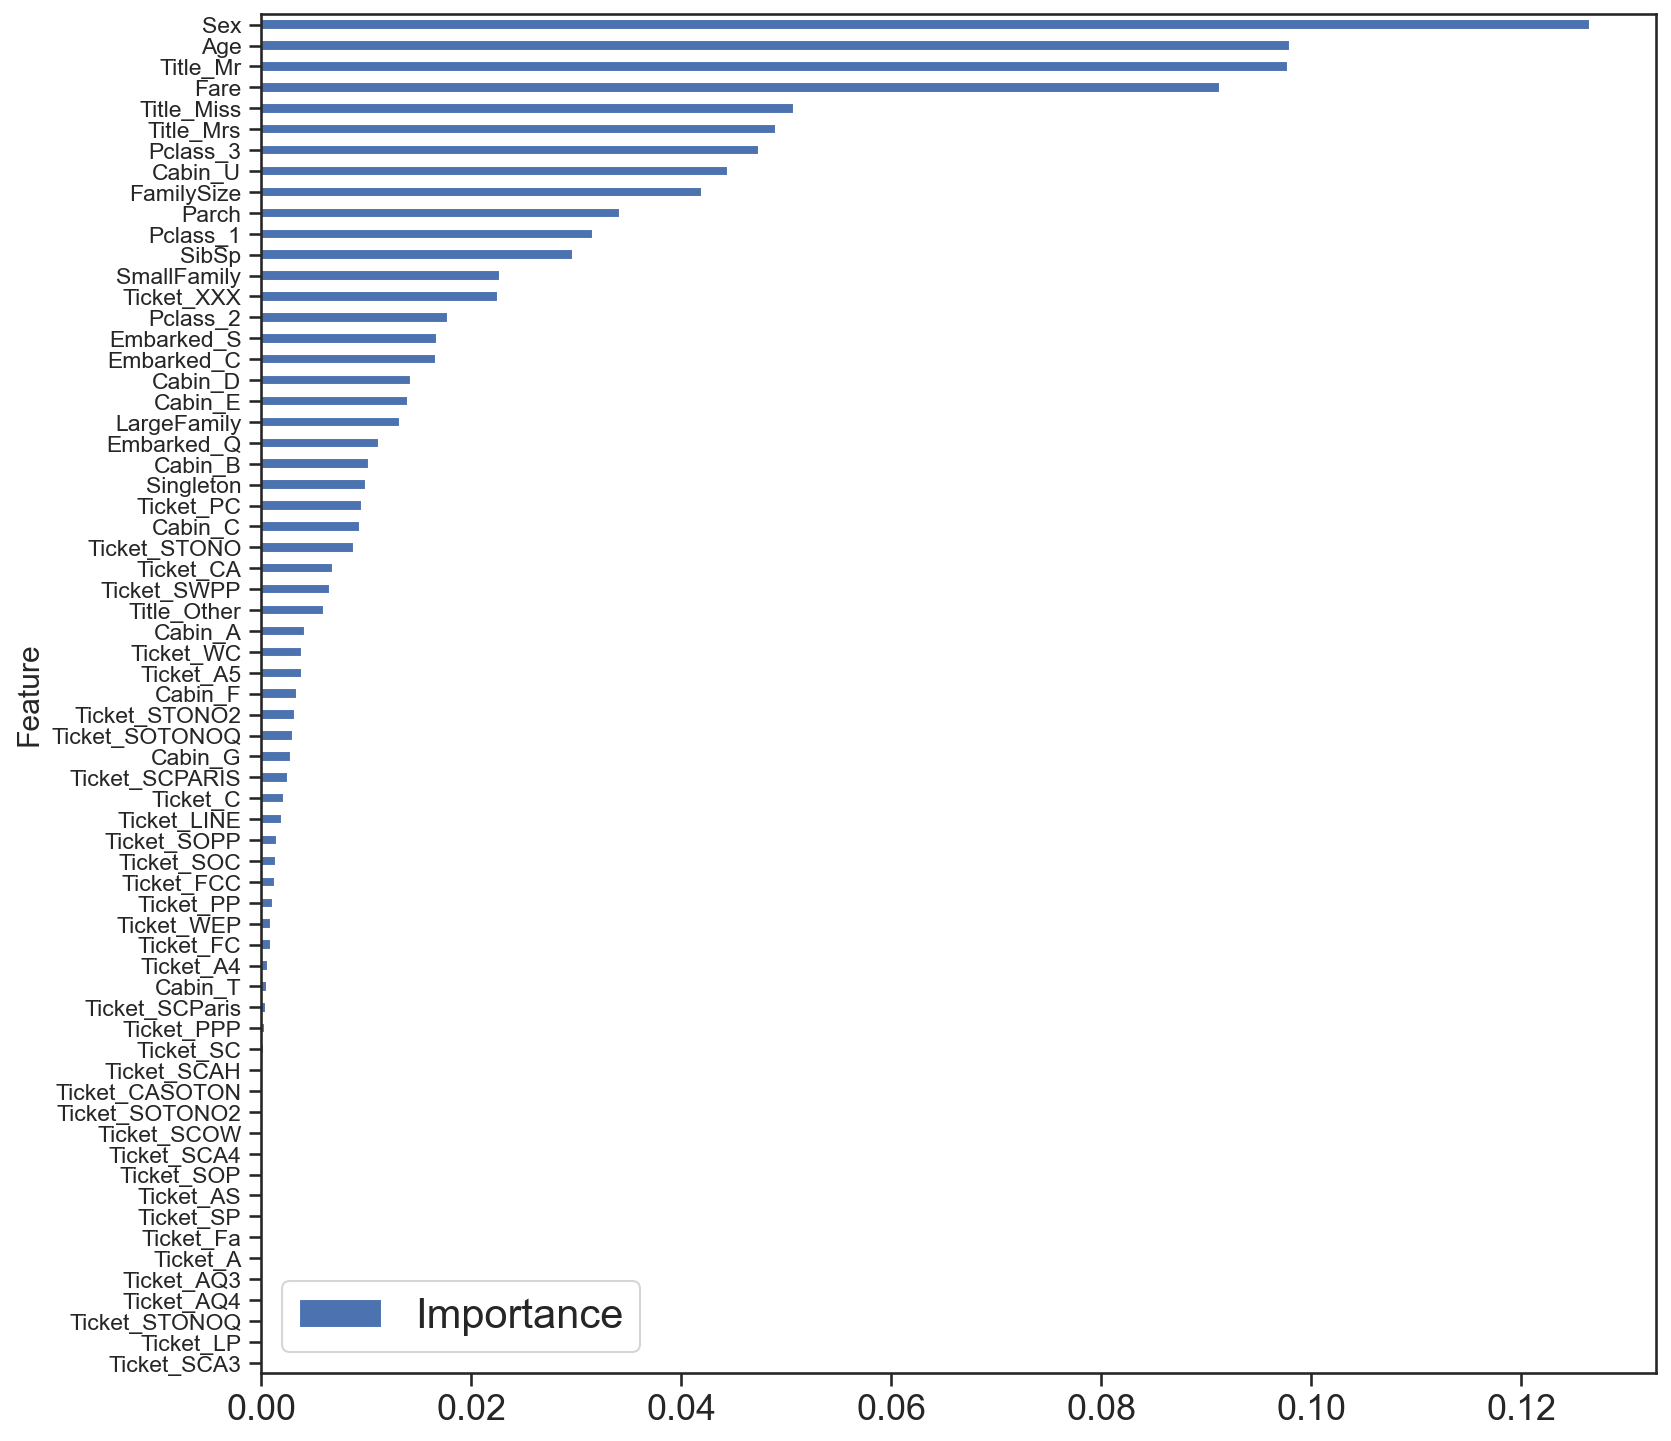

In [79]:
features = pd.DataFrame()
features['Feature'] = train_x.columns
features['Importance'] = rfc.feature_importances_
features.sort_values(by=['Importance'], ascending=True, inplace=True)
features.set_index('Feature', inplace=True)

features.plot(kind='barh', figsize=(12, 12))

As you may notice, there is a great importance linked to Title_Mr, Age, Sex and Fare.

In [80]:
# Reduce the number of features in train and test datasets
model = SelectFromModel(rfc, prefit=True)
train_reduced = model.transform(train_x)
print(train_reduced.shape)

validation_reduced = model.transform(validation)
print(validation_reduced.shape)
print(train_y.shape)

(891, 17)
(418, 17)
(891,)


## Baseline

Let's create a baseline of performance on this problem and spot-check a number of different
algorithms. The six algorithms selected include:

 - Linear Algorithms: Logistic Regression (LR) and Linear Discriminant Analysis (LDA)
 - Nonlinear Algorithms: Classification and Regression Trees (CART), Support Vector
Machines (SVM), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

In [81]:
# Test options and evaluation metric
num_folds = 10
seed = None
scoring = 'accuracy'

# Spot-check algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_reduced, train_y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print("\n[%s] Mean: %.8f Std. Dev.: %8f" %(name, cv_results.mean(), cv_results.std()))


[LR] Mean: 0.80471910 Std. Dev.: 0.020778

[LDA] Mean: 0.81032459 Std. Dev.: 0.024332

[KNN] Mean: 0.79244694 Std. Dev.: 0.041884

[CART] Mean: 0.78902622 Std. Dev.: 0.031505

[NB] Mean: 0.77103620 Std. Dev.: 0.029434

[SVM] Mean: 0.81706617 Std. Dev.: 0.035508


The results suggest that Support Vector Machines may be worth further study.

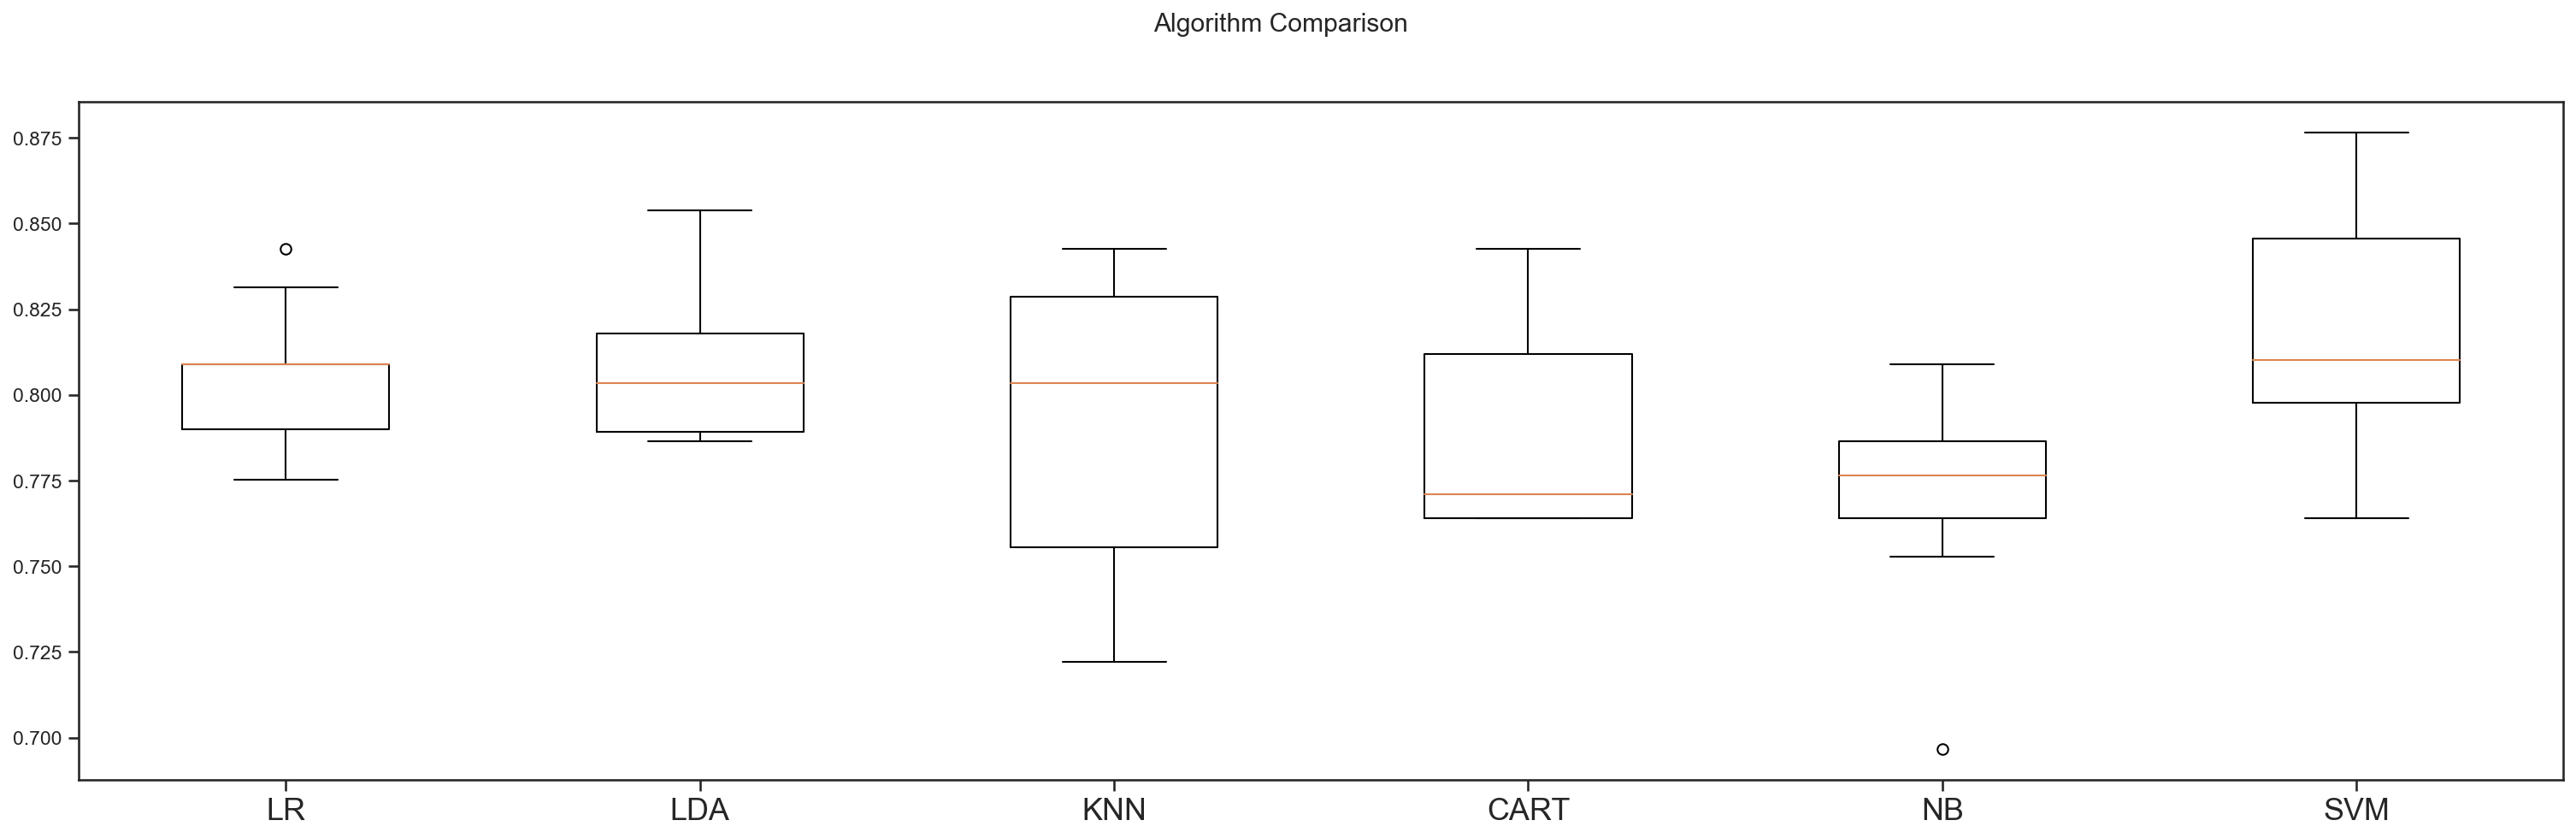

In [82]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Algorithm Tuning

We investigate tuning the parameters for the algorithms that showed promise from
the spot-checking in the previous section: SVM.


### Tuning SVM


We can tune two key parameters of the SVM algorithm, the value of C (how much to relax the
margin) and the type of kernel. The default for SVM (the SVC class) is to use the Radial
Basis Function (RBF) kernel with a C value set to 1.0. Like with KNN, we will perform a grid search using 10-fold cross validation with a standardized copy of the training dataset. We will try a number of simpler kernel types and C values with less bias and more bias (less than and more than 1.0 respectively).

In [83]:
# Tune SVM
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(train_reduced, train_y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.822672 using {'C': 0.9, 'kernel': 'poly'}
0.793483 (0.036684) with: {'C': 0.1, 'kernel': 'linear'}
0.790225 (0.050148) with: {'C': 0.1, 'kernel': 'poly'}
0.804732 (0.032905) with: {'C': 0.1, 'kernel': 'rbf'}
0.685743 (0.061139) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.793483 (0.036684) with: {'C': 0.3, 'kernel': 'linear'}
0.787928 (0.030743) with: {'C': 0.3, 'kernel': 'poly'}
0.808090 (0.030270) with: {'C': 0.3, 'kernel': 'rbf'}
0.721698 (0.039836) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.793483 (0.036684) with: {'C': 0.5, 'kernel': 'linear'}
0.807016 (0.039455) with: {'C': 0.5, 'kernel': 'poly'}
0.811461 (0.032401) with: {'C': 0.5, 'kernel': 'rbf'}
0.657840 (0.069514) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.793483 (0.036684) with: {'C': 0.7, 'kernel': 'linear'}
0.811498 (0.038872) with: {'C': 0.7, 'kernel': 'poly'}
0.812584 (0.034744) with: {'C': 0.7, 'kernel': 'rbf'}
0.711536 (0.045650) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.793483 (0.036684) with: {'C': 0.9, 'kernel': 'linear

We can see the most accurate configuration was SVM with an Poly kernel and C=0.9. The accuracy 82.2267% is seemingly better than what KNN could achieve.

## Ensemble Methods


Another way that we can improve the performance of algorithms on this problem is by using
ensemble methods. We will evaluate four different ensemble machine learning
algorithms, two boosting and two bagging methods:
    
 - Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM).
 - Bagging Methods: Random Forests (RF) and Extra Trees (ET).

We will use the same test harness as before, 10-fold cross validation. No data standardization is used in this case because all four ensemble algorithms are based on decision trees that are less sensitive to data distributions.

In [84]:
# Ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_reduced, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("\n[%s] Mean: %.8f Std. Dev.: %8f" %(name, cv_results.mean(), cv_results.std()))    


[AB] Mean: 0.79574282 Std. Dev.: 0.021701

[GBM] Mean: 0.81932584 Std. Dev.: 0.046078

[RF] Mean: 0.79464419 Std. Dev.: 0.031559

[ET] Mean: 0.79576779 Std. Dev.: 0.028940


We can see that both boosting techniques provide strong accuracy scores in the low 80s (%)
with default configurations. We can plot the distribution of accuracy scores across the cross
validation folds.

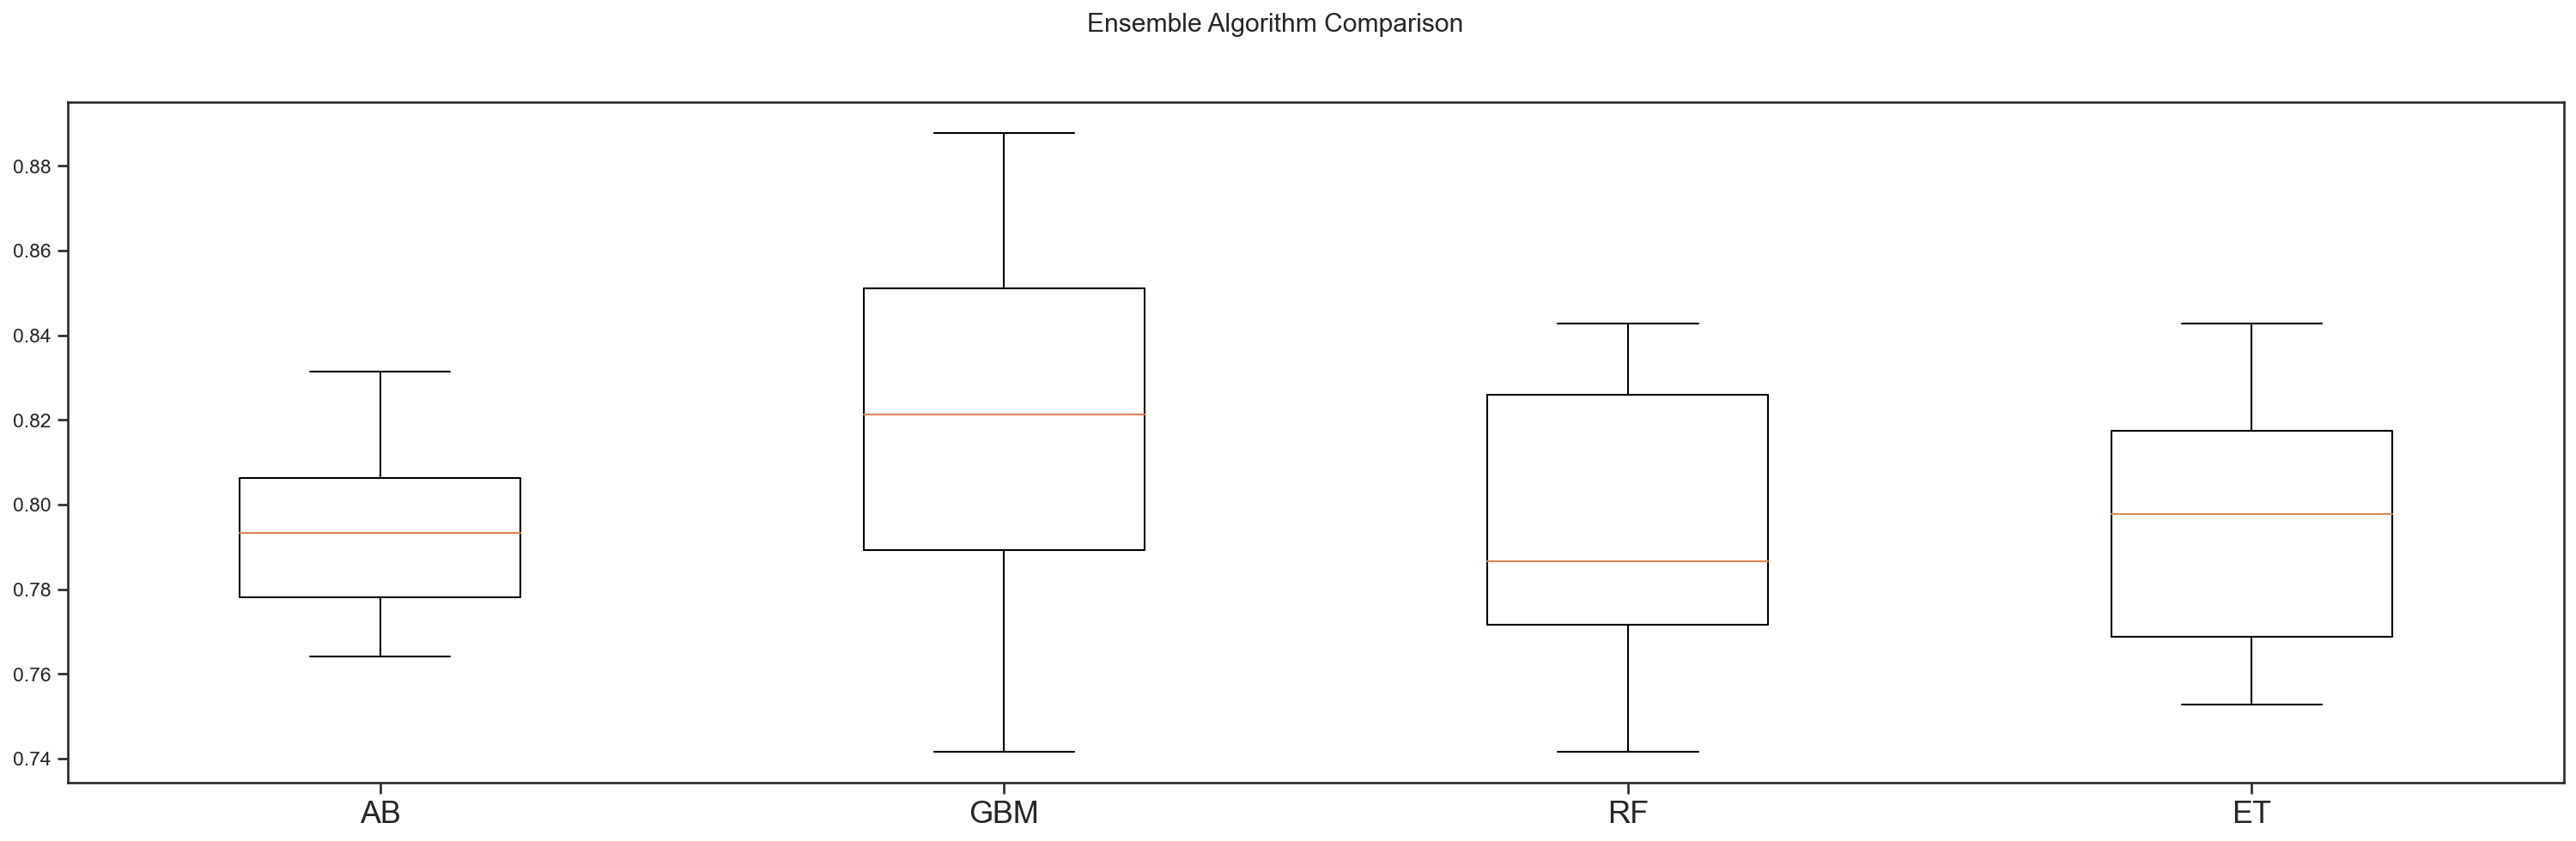

In [86]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

The results suggest GBM may be worthy of further study, with a strong mean and a spread
that skews up towards high 80s (%) in accuracy.

## Finalize Model


The SVM showed the most promise as a low complexity and stable model for this problem. We will finalize the model by training it on the entire training dataset and make predictions for the hold-out validation dataset to confirm our  findings.

Accuracy on train data: 82% 

Confusion Matrix in Numbers
[[492  57]
 [ 99 243]]

Confusion Matrix in Percentage

[[0.9  0.1 ]
 [0.29 0.71]]

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       549
           1       0.81      0.71      0.76       342

    accuracy                           0.82       891
   macro avg       0.82      0.80      0.81       891
weighted avg       0.82      0.82      0.82       891



<AxesSubplot:>

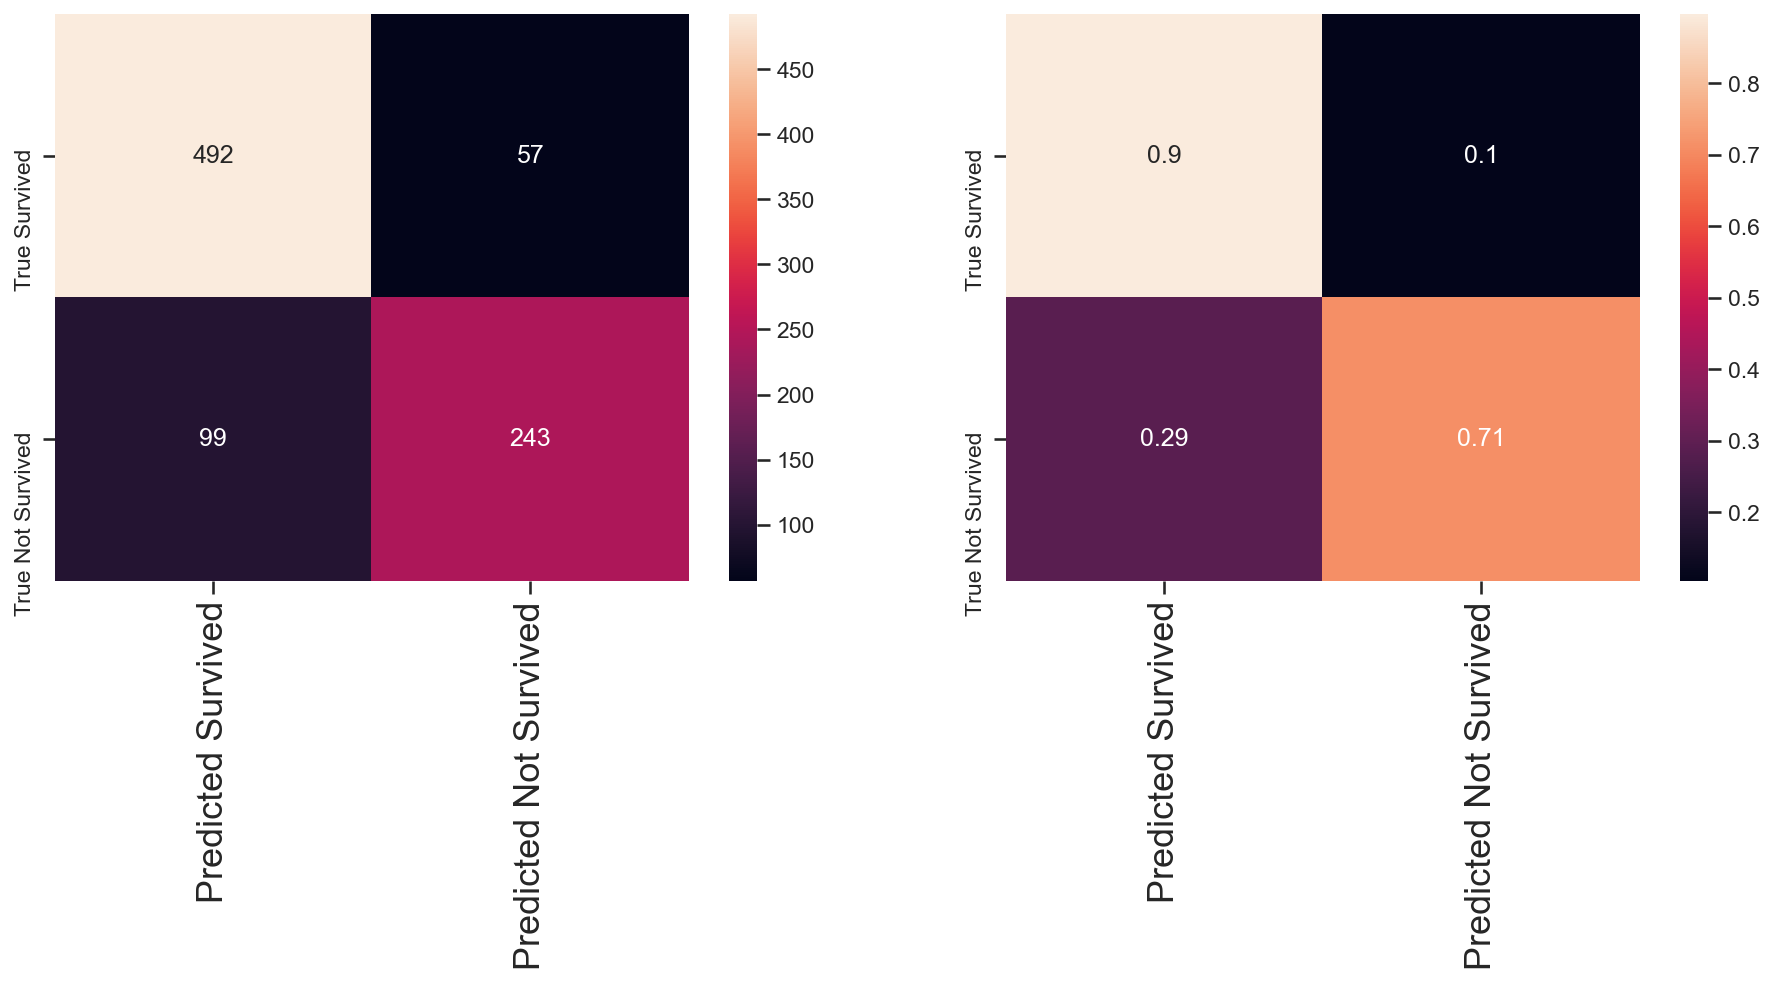

In [92]:
# Fit the model
model = SVC(C=0.9)
model.fit(train_reduced, train_y)

# Prediction on validation data
predictions = model.predict(validation_reduced)

# Estimate accuracy on training dataset 
predictions_train_data = model.predict(train_reduced)

accuracy_svm = round(model.score(train_reduced, train_y) * 100, 4)
print ("Accuracy on train data: %i%% \n"% accuracy_svm)

class_names = ['Survived', 'Not Survived']

# Compute confusion matrix
cnf_matrix = confusion_matrix(train_y, predictions_train_data)
np.set_printoptions(precision=2)

print ('Confusion Matrix in Numbers')
print (cnf_matrix)
print ('')

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

print ('Confusion Matrix in Percentage\n')
print (cnf_matrix_percent)
print ('')


print(classification_report(train_y, predictions_train_data))



true_class_names = ['True Survived', 'True Not Survived']
predicted_class_names = ['Predicted Survived', 'Predicted Not Survived']

df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

plt.figure(figsize = (15,5))

plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, fmt='d')

plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True)


In [90]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })

In [91]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## References¶

This notebook is created by learning from the following notebooks:

 - https://www.kaggle.com/chapagain/titanic-solution-a-beginner-s-guide?scriptVersionId=1473689
 - https://olegleyz.github.io/titanic_factors.html
 - https://www.codeastar.com/data-wrangling/